In [16]:
# ============================================================
# 1. Imports and Setup
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

torch.manual_seed(1337)
np.random.seed(1337)


In [17]:
# ============================================================
# 2. Custom make_moons() without sklearn
# ============================================================
def make_moons_custom(n_samples=500, noise=0.2, random_state=None):
    if random_state is not None:
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random

    n_out = n_samples // 2
    n_in = n_samples - n_out

    # Outer moon
    theta_out = rng.uniform(0, np.pi, n_out)
    x_out = np.stack([np.cos(theta_out), np.sin(theta_out)], axis=1)

    # Inner moon (shifted + flipped)
    theta_in = rng.uniform(0, np.pi, n_in)
    x_in = np.stack([1 - np.cos(theta_in), 1 - np.sin(theta_in) - 0.5], axis=1)

    X = np.concatenate([x_out, x_in], axis=0)
    y = np.concatenate([np.zeros(n_out), np.ones(n_in)])
    X += noise * rng.randn(*X.shape)
    return X, y


In [18]:
# ============================================================
# 3. Generate datasets with different noise levels
# ============================================================
X_train, y_train = make_moons_custom(500, noise=0.2, random_state=1337)
X_test_10, y_test_10 = make_moons_custom(500, noise=0.1, random_state=42)
X_test_20, y_test_20 = make_moons_custom(500, noise=0.2, random_state=999)
X_test_30, y_test_30 = make_moons_custom(500, noise=0.3, random_state=2025)

# Validation split (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1337, stratify=y_train
)

# Standardize using training statistics
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_10_s = scaler.transform(X_test_10)
X_test_20_s = scaler.transform(X_test_20)
X_test_30_s = scaler.transform(X_test_30)


In [19]:
# ============================================================
# 4. Define Simple MLP model
# ============================================================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden1=4, hidden2=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


In [20]:
# ============================================================
# 5. Training function (with early stopping + L1/L2)
# ============================================================
def train_model(model, X_train, y_train, X_val, y_val,
                lr=1e-3, max_epochs=2000, patience=50,
                l1_lambda=0.0, l2_lambda=0.0):

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    best_val_auc = 0.0
    best_state = None
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)

        # Add regularization
        if l1_lambda > 0:
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_penalty
        if l2_lambda > 0:
            l2_penalty = sum((p**2).sum() for p in model.parameters())
            loss += l2_lambda * l2_penalty

        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_t).numpy()
        val_auc = roc_auc_score(y_val, y_val_pred)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return best_val_auc


In [21]:
# ============================================================
# 6. Train models
# ============================================================

# (1) MLP (Early Stopping)
mlp_base = SimpleMLP()
auc_base = train_model(mlp_base, X_train_s, y_train, X_val_s, y_val)
print(f"MLP Base Validation AUROC = {auc_base:.3f}")

# (2) MLP with L1 regularization
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
for l1 in l1_grid:
    model = SimpleMLP()
    auc = train_model(model, X_train_s, y_train, X_val_s, y_val, l1_lambda=l1)
    with torch.no_grad():
        sparsity = sum((p==0).sum().item() for p in model.parameters())
        total_params = sum(p.numel() for p in model.parameters())
        sparsity_ratio = sparsity / total_params
    l1_results.append((l1, auc, sparsity_ratio))
    print(f"L1={l1:.0e}, Val AUROC={auc:.3f}, Sparsity={sparsity_ratio:.3f}")

# Best L1
best_l1 = max(l1_results, key=lambda x: x[1])[0]
mlp_l1 = SimpleMLP()
train_model(mlp_l1, X_train_s, y_train, X_val_s, y_val, l1_lambda=best_l1)

# (3) MLP with L2 regularization
l2_grid = [1e-5, 1e-4, 1e-3, 1e-2]
l2_results = []
for l2 in l2_grid:
    model = SimpleMLP()
    auc = train_model(model, X_train_s, y_train, X_val_s, y_val, l2_lambda=l2)
    l2_results.append((l2, auc))
best_l2 = max(l2_results, key=lambda x: x[1])[0]
mlp_l2 = SimpleMLP()
train_model(mlp_l2, X_train_s, y_train, X_val_s, y_val, l2_lambda=best_l2)


MLP Base Validation AUROC = 0.969
L1=1e-06, Val AUROC=0.981, Sparsity=0.000
L1=3e-06, Val AUROC=0.922, Sparsity=0.000
L1=1e-05, Val AUROC=0.962, Sparsity=0.000
L1=3e-05, Val AUROC=0.945, Sparsity=0.000
L1=1e-04, Val AUROC=0.955, Sparsity=0.000
L1=3e-04, Val AUROC=0.955, Sparsity=0.000


np.float64(0.9456)

In [22]:
# ============================================================
# 7. Logistic Regression with Polynomial Features
# ============================================================
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_p = poly.fit_transform(X_train_s)
X_val_p = poly.transform(X_val_s)
X_test_20_p = poly.transform(X_test_20_s)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_p, y_train)


LogisticRegression(max_iter=5000)

In [23]:
# ============================================================
# 8. Evaluation helper
# ============================================================
def test_metrics(model, X, y, logistic=False, poly=None):
    if logistic:
        probs = model.predict_proba(poly.transform(X))[:,1]
    else:
        with torch.no_grad():
            probs = model(torch.tensor(X, dtype=torch.float32)).numpy().ravel()
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y, preds)
    auc = roc_auc_score(y, probs)
    return acc, auc


In [24]:
# ============================================================
# 9. Evaluate all models on all test noise levels
# ============================================================
models = {
    "MLP (EarlyStop)": mlp_base,
    "MLP (L1)": mlp_l1,
    "MLP (L2)": mlp_l2,
    "Logistic (Poly)": logreg
}

results = {}
for name, model in models.items():
    if name == "Logistic (Poly)":
        acc10, auc10 = test_metrics(model, X_test_10_s, y_test_10, True, poly)
        acc20, auc20 = test_metrics(model, X_test_20_s, y_test_20, True, poly)
        acc30, auc30 = test_metrics(model, X_test_30_s, y_test_30, True, poly)
    else:
        acc10, auc10 = test_metrics(model, X_test_10_s, y_test_10)
        acc20, auc20 = test_metrics(model, X_test_20_s, y_test_20)
        acc30, auc30 = test_metrics(model, X_test_30_s, y_test_30)
    results[name] = (acc10, acc20, acc30, auc20)

import pandas as pd
df_results = pd.DataFrame(results, index=["Acc (0.1)", "Acc (0.2)", "Acc (0.3)", "AUROC (0.2)"]).T
df_results


,Acc (0.1),Acc (0.2),Acc (0.3),AUROC (0.2)
MLP (EarlyStop),0.884,0.890,0.848,0.952720
MLP (L1),0.814,0.838,0.798,0.913792
MLP (L2),0.844,0.876,0.834,0.947024
Logistic (Poly),0.848,0.876,0.836,0.947984


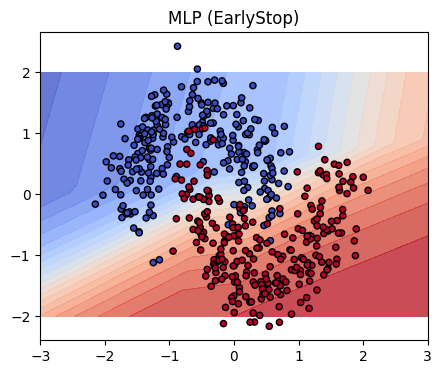

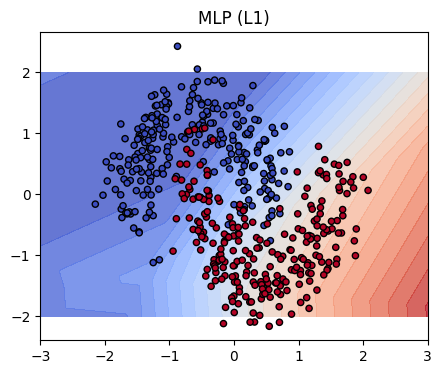

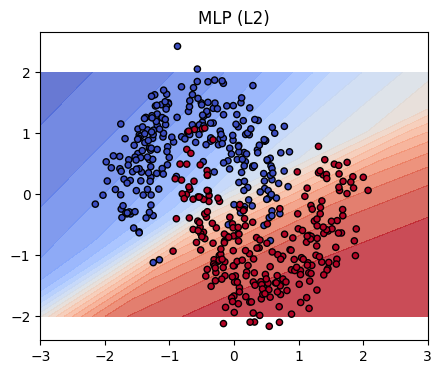

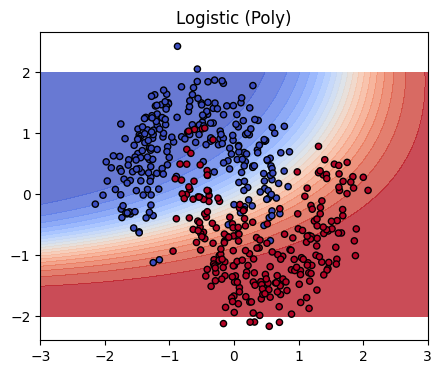

In [25]:
# ============================================================
# 10. Decision Boundary Plots (noise=0.2)
# ============================================================
def plot_decision_boundary(model, X, y, title, logistic=False, poly=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-2, 2, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    if logistic:
        zz = model.predict_proba(poly.transform(grid))[:,1]
    else:
        with torch.no_grad():
            zz = model(torch.tensor(grid, dtype=torch.float32)).numpy().ravel()
    zz = zz.reshape(xx.shape)
    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, zz, levels=20, cmap='coolwarm', alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', cmap='coolwarm', s=20)
    plt.title(title)
    plt.show()

plot_decision_boundary(mlp_base, X_test_20_s, y_test_20, "MLP (EarlyStop)")
plot_decision_boundary(mlp_l1, X_test_20_s, y_test_20, "MLP (L1)")
plot_decision_boundary(mlp_l2, X_test_20_s, y_test_20, "MLP (L2)")
plot_decision_boundary(logreg, X_test_20_s, y_test_20, "Logistic (Poly)", logistic=True, poly=poly)


In [26]:
# ============================================================
# 11. Class Imbalance Experiment (70:30)
# ============================================================
# Make imbalanced version of training data
idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]
rng = np.random.RandomState(1337)
idx_1_down = rng.choice(idx_1, size=int(0.3 * len(idx_1)), replace=False)
imbal_idx = np.concatenate([idx_0, idx_1_down])
X_train_imb = X_train_s[imbal_idx]
y_train_imb = y_train[imbal_idx]

# Retrain best model (e.g. MLP L2)
mlp_imb = SimpleMLP()
train_model(mlp_imb, X_train_imb, y_train_imb, X_val_s, y_val, l2_lambda=best_l2)

acc_imb, auc_imb = test_metrics(mlp_imb, X_test_20_s, y_test_20)
print(f"Imbalanced Train - Test Acc: {acc_imb:.3f}, AUROC: {auc_imb:.3f}")


Imbalanced Train - Test Acc: 0.682, AUROC: 0.858


##  Discussion / Analysis Summary

| **Concept** | **Effect** |
|--------------|------------|
| **L1 Regularization** | Pushes many weights to **zero → sparse network**. This leads to more jagged decision boundaries due to fewer active neurons. Helps interpretability. |
| **L2 Regularization** | Penalizes large weights, resulting in **smoother decision boundaries and larger margin**. Improves robustness to noise. |
| **Early Stopping** | Prevents overfitting by halting training when validation AUROC no longer improves. |
| **Class Imbalance (70:30)** | Reduces AUROC and may cause bias toward the majority class. Accuracy alone becomes misleading — AUROC provides better performance insight. |

